In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, wishart
from scipy.special import digamma
import data, random

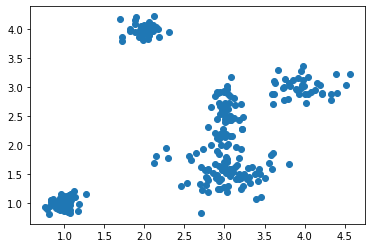

In [2]:
centers_x = [1, 2,   3,   3, 4]
centers_y = [1, 4, 1.5, 2.5, 3]
covs = [np.array([[1, 0],[0, 1]]), 
        np.array([[2, 0.3],[0.3, 1]]),
        np.array([[10, -0.3],[-0.3, 4]]),
        np.array([[1, 0.3],[0.3, 10]]), 
        np.array([[5, 0.1],[0.1, 2]])]
datanums = [60, 40, 80, 60, 40]

K = 10

data = []

for i in range(5):
    p = multivariate_normal((centers_x[i], centers_y[i]), covs[i]/100)
    data.extend(p.rvs(datanums[i]))
    
#random.shuffle(data)
data.sort(key = lambda x: x[0])
#print(data)

plt.scatter([x for (x,y) in data], [y for (x,y) in data])


In [3]:

def initial_r(data):
    rs = []
    for i,d in enumerate(data):
        r = [0]*K
        p = int(i/len(data)*K)
        r[p] = 1.0
        
        rs.append(r)
        
    return rs

In [4]:
rs = initial_r(data)

In [5]:
def weighted_num(k, rs):
    return sum([r[k] for r in rs])

def weighted_mean(k, rs, data):
    return sum([ r[k]*p for (r, p) in zip(rs, data)])/weighted_num(k, rs)
    
def weighted_cov(k, rs, data):
    xbar = weighted_mean(k, rs, data)
    return sum([ r[k]*(p-xbar).reshape((2, 1)).dot((p-xbar).reshape((2, 1)).T) for (r, p) in zip(rs, data)])/weighted_num(k, rs)

In [6]:
def update_params(org_alpha, org_beta, org_nu, org_m, org_w_inv, k, ns, xs, covs):
    alpha = org_alpha + ns[k]
    beta = org_beta + ns[k]
    nu = org_nu + ns[k]
    m = (org_beta * org_m + ns[k]*xs[k])/beta
    w_inv = org_w_inv + ns[k]*covs[k] + (org_beta*ns[k])/(org_beta + ns[k])*(xs[k] - org_m).reshape((2,1)).dot((xs[k] - org_m).reshape((2,1)).T)
    
    return (alpha, beta, nu, m, w_inv)

In [7]:
def rho(d, k, alphas, betas, nus, ms, w_invs):
    first = digamma(alphas[k]) - digamma(sum(alphas))
    second_2 = digamma((nus[k])/2) + digamma((nus[k] - 1)/2) + np.log(1/np.linalg.det(w_invs[k]))
    third_2 = 2/betas[k] + nus[k]*(d - ms[k]).reshape((2,1)).T.dot(np.linalg.inv(w_invs[k])).dot((d - ms[k]).reshape((2,1)))[0][0]
    
    log_rho = first + second_2/2 - third_2/2
    
    return np.exp(log_rho)

In [8]:
def calc_rs(alphas, betas, nus, ms, w_invs):
    rs = []
    for d in data:
        rhos = [ rho(d, k, alphas, betas, nus, ms, w_invs) for k in range(K)]
        sm = sum(rhos)
        rs.append(rhos/sm)
        
    return rs

In [9]:
def graph(data, ms, betas, w_invs, ns):
    plt.scatter([x for (x,y) in data], [y for (x,y) in data])
    plt.scatter([x for (x,y) in ms], [y for (x,y) in ms], color="red")
    sigmas = [ w_invs[k]/betas[k]/2 for k in range(K)]
    
    normals = [multivariate_normal(mean=ms[k], cov=sigmas[k]) for k in range(K) ]
    
    x, y = np.mgrid[0:5:100j, 0:4:100j]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y 

    for k,n in enumerate(normals):
        if ns[k] > 1:
            plt.contour(x, y, n.pdf(pos), levels=3) 
    

In [10]:
alphas = [1]*K
betas = [1]*K
nus = [1]*K
ms = [np.array([0,0])]*K
w_invs = [np.array([[1, 0],[0, 1]])]*K

In [11]:

def one_step(rs):
    ns = [weighted_num(k, rs) for k in range(K)]
    xs = [weighted_mean(k, rs, data) for k in range(K)]
    covs = [weighted_cov(k, rs, data) for k in range(K)]

    print(ns)
    for k in range(K):
        if ns[k] < 0.01:
         #   ms[k] = np.array([0,0])
            continue
            
        params = update_params(1,1,1, np.mean(data), np.array([[1, 0],[0, 1]]), k, ns, xs, covs)
        alphas[k] = params[0]
        betas[k] = params[1]
        nus[k] = params[2]
        ms[k] = params[3]
        w_invs[k] = params[4]

    
    graph(data, ms, betas, w_invs, ns)
    return calc_rs(alphas, betas, nus, ms, w_invs)
    
#    print(alphas)
#    print(betas)
#    print(nus)

#    print(w_invs)
#    print(ms) 
#    print(rs)

[28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]


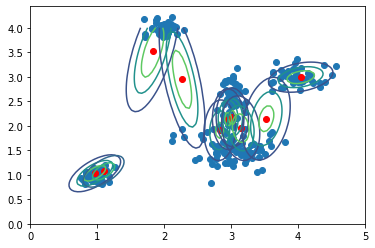

In [12]:
rs = one_step(rs)

In [13]:
print(ms)

[array([0.96506963, 1.03067217]), array([1.0964549 , 1.07060494]), array([1.82896004, 3.51995954]), array([2.26780186, 2.94516111]), array([2.83016853, 1.90817874]), array([2.95563931, 2.13466351]), array([3.01713291, 2.1711712 ]), array([3.14408064, 1.95086079]), array([3.52609454, 2.1450334 ]), array([4.03966953, 2.99144444])]


[3.812407325843929e-45, 60.00126921105334, 39.99978438096089, 0.002482432666128499, 0.0010841627568240727, 7.587166341536306e-05, 54.700344077276135, 82.12537723163463, 0.0009815270382726616, 43.168601104950305]
[3.812574960057961e-45, 60.00127385973747, 39.999784379062945, 0.002482541537056117, 0.0010842040733113323, 7.587452909141119e-05, 54.47316634964833, 82.38693586529006, 0.0009815644277733411, 43.13421536169385]
[3.812710897065694e-45, 60.00127782769423, 39.99978437493325, 0.0024826297464486035, 0.0010842367391752038, 7.587676791032499e-05, 54.28820024357908, 82.59960567454527, 0.0009815943062560007, 43.106507541688394]
[3.812818994147927e-45, 60.00128116313619, 39.99978437003636, 0.0024826996843673173, 0.0010842619936492009, 7.587847928681853e-05, 54.13896154900374, 82.77090396226626, 0.0009816176511481774, 43.084444497749026]
[3.8129043263718504e-45, 60.00128392859997, 39.999784365197286, 0.0024827546627978407, 0.0010842813784782863, 7.587977919895011e-05, 54.01943603425251, 8

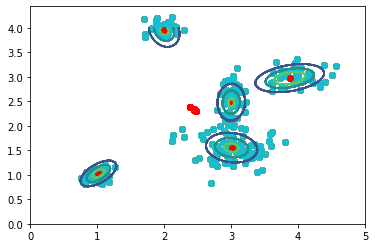

In [19]:
for _ in range(20):
    rs = one_step(rs)

[3.8132262979503455e-45, 60.00129480362652, 39.99978434277495, 0.002482959088116079, 0.0010843505365851823, 7.588432090407627e-05, 53.583497208476864, 83.40277917927918, 0.0009817018493110206, 43.00801957004752]


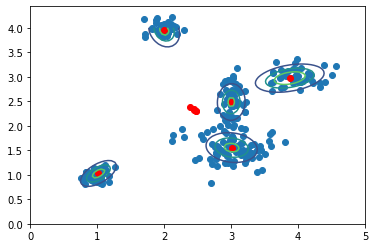

In [20]:
rs = one_step(rs)